SVM对比分析
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import theano
from theano import shared
floatX = theano.config.floatX
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from sklearn import svm

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from RMSE import *
%matplotlib inline

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\1.svg', format='svg')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 18, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\2.svg', format='svg')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(18, 25, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\3.svg', format='svg')
    plt.show()
    return 0

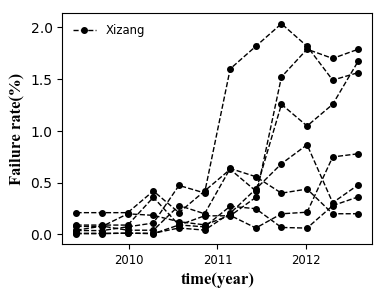

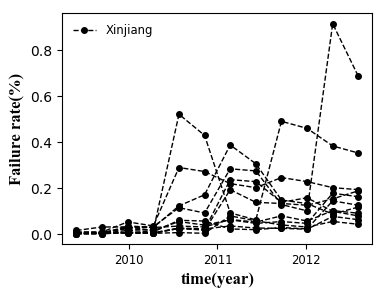

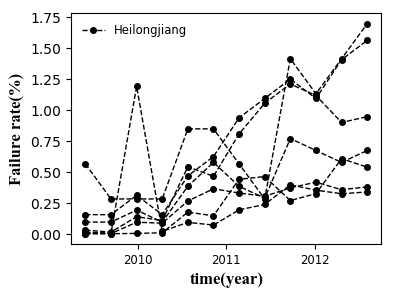

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
Norm_year_Mean = np.mean(elec_year)
Norm_year_std = np.std(elec_year)
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(elec_year1)

elec_data.Fault.values[202] =200
elec_data.Fault.values[203] =150
elec_data.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(25)])
elec_year2 = np.array([elec_year1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char1 = np.array([elec_tem1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char2 = np.array([elec_hPa1[i*12:(i+1)*12] for i in np.arange(25)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(25)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_tem1))
xs_char2 = shared(np.asarray(elec_hPa1))
xs_char3 = shared(np.asarray(elec_RH1))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year1))
Num_shared = shared(np.asarray(companyABC))
# print(companyABC)
# print(companiesABC)
# print(len(data_cs_year))
# print(len(elec_faults))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)


def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

# 支持向量机
---

In [4]:
# 支持向量机
from sklearn import svm
from DataSplitOne import *

In [5]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data_SVM = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num_SVM = elec_data_SVM.counts.unique()
companies_SVM = len(companies_num_SVM)  # companies=7， 共7个测试地点
company_lookup_SVM = dict(zip(companies_num_SVM, range(len(companies_num_SVM))))
company_SVM = elec_data_SVM['company_code'] = elec_data_SVM.counts.replace(company_lookup_SVM).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC_SVM = elec_data_SVM.company.unique()
companiesABC_SVM = len(company_ABC_SVM)  # companies=7， 共7个测试地点
company_lookup_ABC_SVM = dict(zip(company_ABC_SVM, range(len(company_ABC_SVM))))
companyABC_SVM = elec_data_SVM['company_ABC'] = elec_data_SVM.company.replace(company_lookup_ABC_SVM).values  # 加一行数据在XZsingal文件中
# 给所有特征因素加上高斯噪声
SNR_SVM = np.random.normal(0, 1, size=[len(elec_data_SVM.Year.values), 3])
SNR_SVM1 = np.random.normal(0, 1, size=[len(elec_data_SVM.Year.values), 1])

# #特征因素分析
elec_tem_SVM = elec_data_SVM.Tem.values  + SNR_SVM1[:, 0] # 观测温度值x2，温度不加噪声
elec_tem1_SVM = (elec_tem_SVM - np.mean(elec_tem_SVM)) / np.std(elec_tem_SVM)

elec_hPa_SVM = elec_data_SVM.hPa.values + SNR_SVM[:, 0]  # 观测压强x3
elec_hPa1_SVM = (elec_hPa_SVM - np.mean(elec_hPa_SVM)) / np.std(elec_hPa_SVM)
elec_RH_SVM = elec_data_SVM.RH.values + SNR_SVM[:, 1] # 观测压强x3
elec_RH1_SVM = (elec_RH_SVM - np.mean(elec_RH_SVM)) / np.std(elec_RH_SVM)
elec_Lux_SVM = elec_data_SVM.Lux.values + SNR_SVM[:, 2] # 观测压强x3
elec_Lux1_SVM = (elec_Lux_SVM - np.mean(elec_Lux_SVM)) / np.std(elec_Lux_SVM)

# 计算观测时间，温度，光照等环境条件
elec_year_SVM = elec_data_SVM.Year.values  # 观测时间值x1
elec_year1_SVM = (elec_year_SVM - np.mean(elec_year_SVM)) / np.std(elec_year_SVM)
Norm_year_Mean = np.mean(elec_year_SVM)
Norm_year_std = np.std(elec_year_SVM)

elec_data.Fault.values[202] =200
elec_data.Fault.values[203] =150
elec_data.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults_SVM = 1*(elec_data_SVM.Fault.values / elec_data_SVM.Nums.values)  # 数组形式,计算故障率大小
elec_faults1_SVM = (elec_faults_SVM - np.mean(elec_faults_SVM)) / np.std(elec_faults_SVM)
Mean_elec_faults = np.mean(elec_faults_SVM)
Norm_faults_std = np.std(elec_faults_SVM)

elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(25)])
elec_year2 = np.array([elec_year1[i*12:(i+1)*12] for i in np.arange(25)])


X_SVM = scale(np.vstack((elec_year1_SVM, elec_tem1_SVM, elec_hPa1_SVM, elec_RH1_SVM)).T)
X_SVM = X_SVM.astype(floatX)
Y_SVM = elec_faults1_SVM #需要对Y进行均值化
Y_SVM = Y_SVM.astype(floatX)
# print(Y_SVM)

X_SVM_XZ = X_SVM[:84, :]
X_SVM_XJ = X_SVM[84:216, :]
X_SVM_HLJ = X_SVM[216:, :]

Y_SVM_XZ = Y_SVM[:84]
Y_SVM_XJ = Y_SVM[84:216]
Y_SVM_HLJ = Y_SVM[216:]
# print(X_SVM_XJ)

# print(np.shape(X_train_XJ))

In [6]:
# SVM算法拟合效果，参数如下：
# SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
#     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Y_rbf_XZ = []
II = 10
for i in range(II):
    X_train_XZ, X_test_XZ, Y_train_XZ, Y_test_XZ = DataSplitOne(X_SVM_XZ, Y_SVM_XZ, test_size=.1, GroupSize_Init=7, SubSize=12)
    vr_rbf_XZ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_rbf_XZ = vr_rbf_XZ.fit(X_train_XZ, Y_train_XZ).predict(X_test_XZ)
    Y_rbf_XZ.append(y_rbf_XZ)
Y_rbf_XZ = np.mean(Y_rbf_XZ, axis=0)
print(Y_rbf_XZ)

Y_rbf_XJ = []
for i in range(II+5):
    X_train_XJ, X_test_XJ, Y_train_XJ, Y_test_XJ = DataSplitOne(X_SVM_XJ, Y_SVM_XJ, test_size=.01, GroupSize_Init=11, SubSize=12)
    vr_rbf_XJ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_rbf_XJ = vr_rbf_XJ.fit(X_train_XJ, Y_train_XJ).predict(X_test_XJ)
    Y_rbf_XJ.append(y_rbf_XJ)
Y_rbf_XJ = np.mean(Y_rbf_XJ, axis=0)
print(Y_rbf_XJ)

Y_rbf_HLJ = []
for i in range(II):
    X_train_HLJ, X_test_HLJ, Y_train_HLJ, Y_test_HLJ = DataSplitOne(X_SVM_HLJ, Y_SVM_HLJ, test_size=.1, GroupSize_Init=7, SubSize=12)
    vr_rbf_HLJ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_rbf_HLJ = vr_rbf_HLJ.fit(X_train_HLJ, Y_train_HLJ).predict(X_test_HLJ)
    Y_rbf_HLJ.append(y_rbf_HLJ)
Y_rbf_HLJ = np.mean(Y_rbf_HLJ, axis=0) 
print(Y_rbf_HLJ)

Y_SVMpred = np.vstack((Y_rbf_XZ, Y_rbf_XJ, Y_rbf_HLJ))# Pls预测值
Y_SVMpred = (Y_SVMpred*Norm_faults_std + Mean_elec_faults)*100
print(Y_SVMpred)
# np.savetxt('Y_SVMpred.csv', Y_SVMpred, delimiter = ',')

[-1. -1. -0. -1. -0. -0.  0.  0.  1.  1.  1.  2.]
[-1. -1. -1. -1. -1. -1. -0. -0. -0. -1. -0. -0.]
[-1. -1. -0. -1.  0.  0.  1.  0.  1.  1.  1.  1.]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.]]


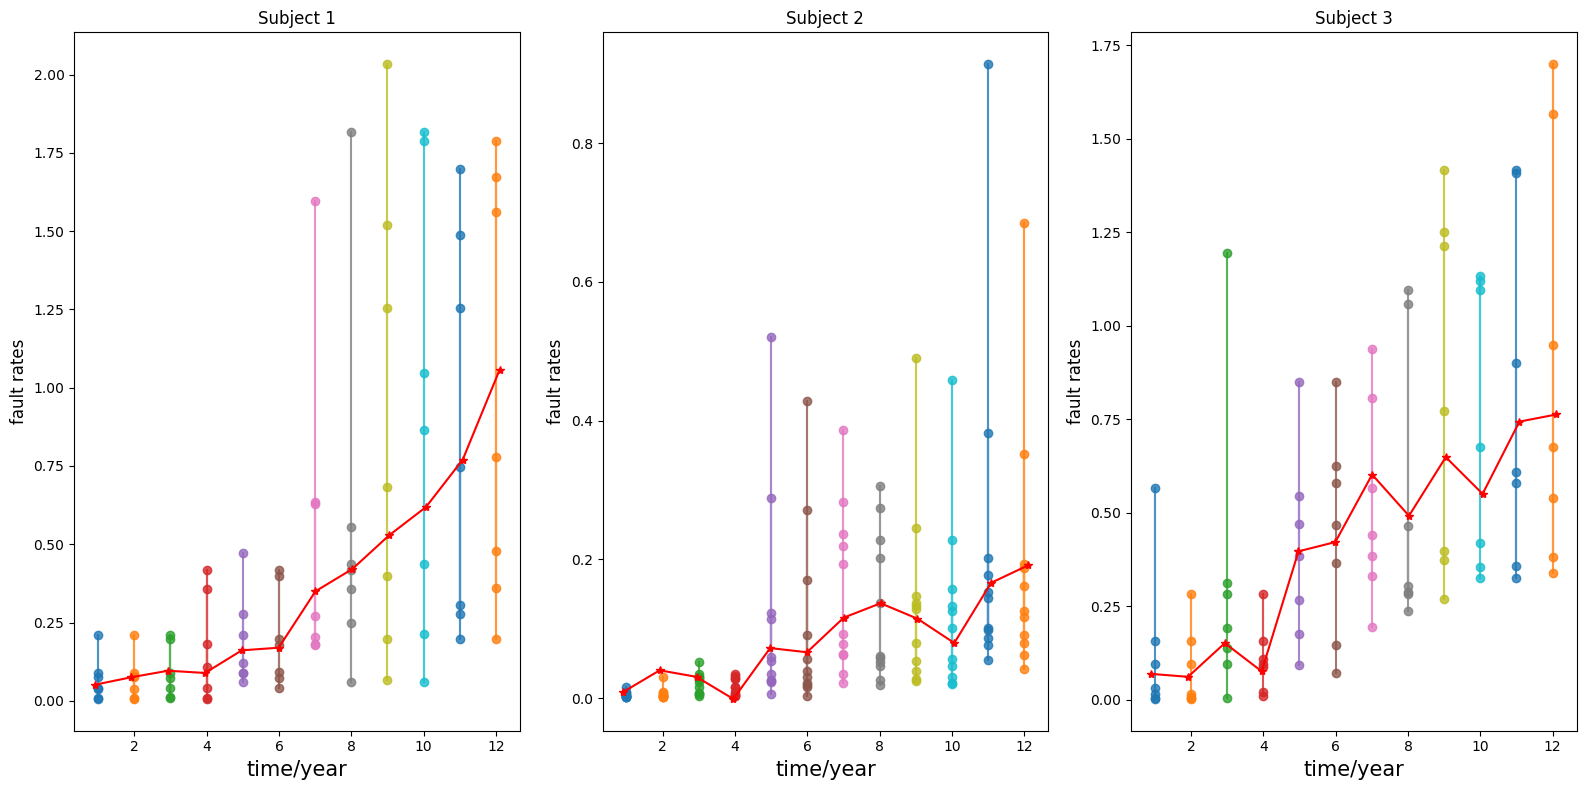

In [7]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3)
xipred = np.array(np.arange(6) + 1)

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]*Norm_year_std + Norm_year_Mean
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    if ip==1:
        xp = elec_year2[ip*7:((ip+1)*7+4), :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[ip*7:((ip+1)*7+4), :]
    if ip==2:
        xp = elec_year2[18:25, :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[18:25, :]
        
    xl = np.linspace(0.9, 12.1, 12)
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = Y_SVMpred[ip]

    ax.plot(xl, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [9]:
RmseTrain_svm, MAETrain_svm, MAPETrain_svm  = RMSE(elec_faults_SVM, Y_SVMpred, Len_One=12, Zoom_factor=100)
print(RmseTrain_svm)
print(MAETrain_svm)
print(MAPETrain_svm)

Rmse Mean is A、B、C :
{0: 0.004733520009830316, 1: 0.0010183210273763178, 2: 0.004809242009281965}
{0: 0.0036115956078958855, 1: 0.0008410801909682012, 2: 0.004103096612765943}
{0: 225.9936863892661, 1: 303.86978167684373, 2: 291.3474222681258}


神经网络
---

In [10]:
from sklearn.neural_network import MLPRegressor

In [11]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data_NN = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num_NN = elec_data_NN.counts.unique()
companies_NN = len(companies_num_NN)  # companies=7， 共7个测试地点
company_lookup_NN = dict(zip(companies_num_NN, range(len(companies_num_NN))))
company_NN = elec_data_NN['company_code'] = elec_data_NN.counts.replace(company_lookup_NN).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC_NN = elec_data_NN.company.unique()
companiesABC_NN = len(company_ABC_NN)  # companies=7， 共7个测试地点
company_lookup_ABC_NN = dict(zip(company_ABC_NN, range(len(company_ABC_NN))))
companyABC_NN = elec_data_NN['company_ABC'] = elec_data_NN.company.replace(company_lookup_ABC_NN).values  # 加一行数据在XZsingal文件中
# 给所有特征因素加上高斯噪声
SNR_NN = np.random.normal(0, 1, size=[len(elec_data_NN.Year.values), 3])
SNR_NN1 = np.random.normal(0, 1, size=[len(elec_data_NN.Year.values), 1])

# #特征因素分析
elec_tem_NN = elec_data_NN.Tem.values  + SNR_NN1[:, 0] # 观测温度值x2，温度不加噪声
elec_tem1_NN = (elec_tem_NN - np.mean(elec_tem_NN)) / np.std(elec_tem_NN)

elec_hPa_NN = elec_data_NN.hPa.values + SNR_NN[:, 0]  # 观测压强x3
elec_hPa1_NN = (elec_hPa_NN - np.mean(elec_hPa_NN)) / np.std(elec_hPa_NN)
elec_RH_NN = elec_data_NN.RH.values + SNR_NN[:, 1] # 观测压强x3
elec_RH1_NN = (elec_RH_NN - np.mean(elec_RH_NN)) / np.std(elec_RH_NN)
elec_Lux_NN = elec_data_NN.Lux.values + SNR_NN[:, 2] # 观测压强x3
elec_Lux1_NN = (elec_Lux_NN - np.mean(elec_Lux_NN)) / np.std(elec_Lux_NN)

# 计算观测时间，温度，光照等环境条件
elec_year_NN = elec_data_NN.Year.values  # 观测时间值x1
elec_year1_NN = (elec_year_NN - np.mean(elec_year_NN)) / np.std(elec_year_NN)
Norm_year_Mean = np.mean(elec_year_NN)
Norm_year_std = np.std(elec_year_NN)

elec_data.Fault.values[202] =200
elec_data.Fault.values[203] =150
elec_data.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults_NN = (elec_data_NN.Fault.values / elec_data_NN.Nums.values)  # 数组形式,计算故障率大小
elec_faults1_NN = (elec_faults_NN - np.mean(elec_faults_NN)) / np.std(elec_faults_NN) #必须要标准化

Mean_elec_faults = np.mean(elec_faults_NN)
Norm_faults_std = np.std(elec_faults_NN)

elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(25)])
elec_year2 = np.array([elec_year1[i*12:(i+1)*12] for i in np.arange(25)])


X_NN = scale(np.vstack((elec_year1_NN, elec_tem1_NN, elec_hPa1_NN, elec_RH1_NN)).T)
X_NN = X_NN.astype(floatX)
Y_NN = elec_faults1_NN #需要对Y进行均值化
Y_NN = Y_NN.astype(floatX)
# print(Y_NN)

X_NN_XZ = X_NN[:84, :] 
X_NN_XJ = X_NN[84:216, :]
X_NN_HLJ = X_NN[216:, :]

Y_NN_XZ = Y_NN[:84]
Y_NN_XJ = Y_NN[84:216]
Y_NN_HLJ = Y_NN[216:]
# print(X_NN_XJ)

# print(np.shape(X_train_XJ))

In [42]:
Y_Pred_XZ = []
II = 10

layer_Size = 4
hidden_Size = 50
for i in range(II):
    X_train_XZ, X_test_XZ, Y_train_XZ, Y_test_XZ = DataSplitOne(X_NN_XZ, Y_NN_XZ, test_size=.1, GroupSize_Init=7, SubSize=12)
    clf_XZ = MLPRegressor(hidden_layer_sizes=(layer_Size, hidden_Size),learning_rate='adaptive', random_state=1, max_iter=10000, warm_start=True)
    y_Pred_XZ = clf_XZ.fit(X_train_XZ, Y_train_XZ).predict(X_test_XZ)
    Y_Pred_XZ.append(y_Pred_XZ)
Y_Pred_XZ = np.mean(Y_Pred_XZ, axis=0)
print(Y_Pred_XZ)

Y_Pred_XJ = []
for i in range(II):
    X_train_XJ, X_test_XJ, Y_train_XJ, Y_test_XJ = DataSplitOne(X_NN_XJ, Y_NN_XJ, test_size=.01, GroupSize_Init=11, SubSize=12)
    clf_XJ = MLPRegressor(hidden_layer_sizes=(layer_Size, hidden_Size), learning_rate='adaptive', random_state=1, max_iter=10000, warm_start=True)
    y_Pred_XJ = clf_XJ.fit(X_train_XJ, Y_train_XJ).predict(X_test_XJ)
    Y_Pred_XJ.append(y_Pred_XJ)
Y_Pred_XJ = np.mean(Y_Pred_XJ, axis=0)
print(Y_Pred_XJ)


Y_Pred_HLJ = []
for i in range(II):
    X_train_HLJ, X_test_HLJ, Y_train_HLJ, Y_test_HLJ = DataSplitOne(X_NN_HLJ, Y_NN_HLJ, test_size=.1, GroupSize_Init=7, SubSize=12)
    clf_HLJ = MLPRegressor(hidden_layer_sizes=(layer_Size, hidden_Size), learning_rate='adaptive', random_state=1, max_iter=10000, warm_start=True)
    y_Pred_HLJ = clf_HLJ.fit(X_train_HLJ, Y_train_HLJ).predict(X_test_HLJ)
    Y_Pred_HLJ.append(y_Pred_HLJ)
Y_Pred_HLJ = np.mean(Y_Pred_HLJ, axis=0)
print(Y_Pred_HLJ)
print(clf_HLJ.get_params([True]))

Y_NNpred = np.vstack((Y_Pred_XZ, Y_Pred_XJ, Y_Pred_HLJ))# Pls预测值
Y_NNpred = (Y_NNpred*Norm_faults_std + Mean_elec_faults)*100
print(Y_NNpred)

[-1. -1. -0. -0. -0. -0.  1.  0.  1.  1.  1.  2.]
[-1. -1. -1. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
[-1. -0. -0. -0.  0.  0.  1.  1.  1.  1.  1.  1.]
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (4, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': True}
[[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]


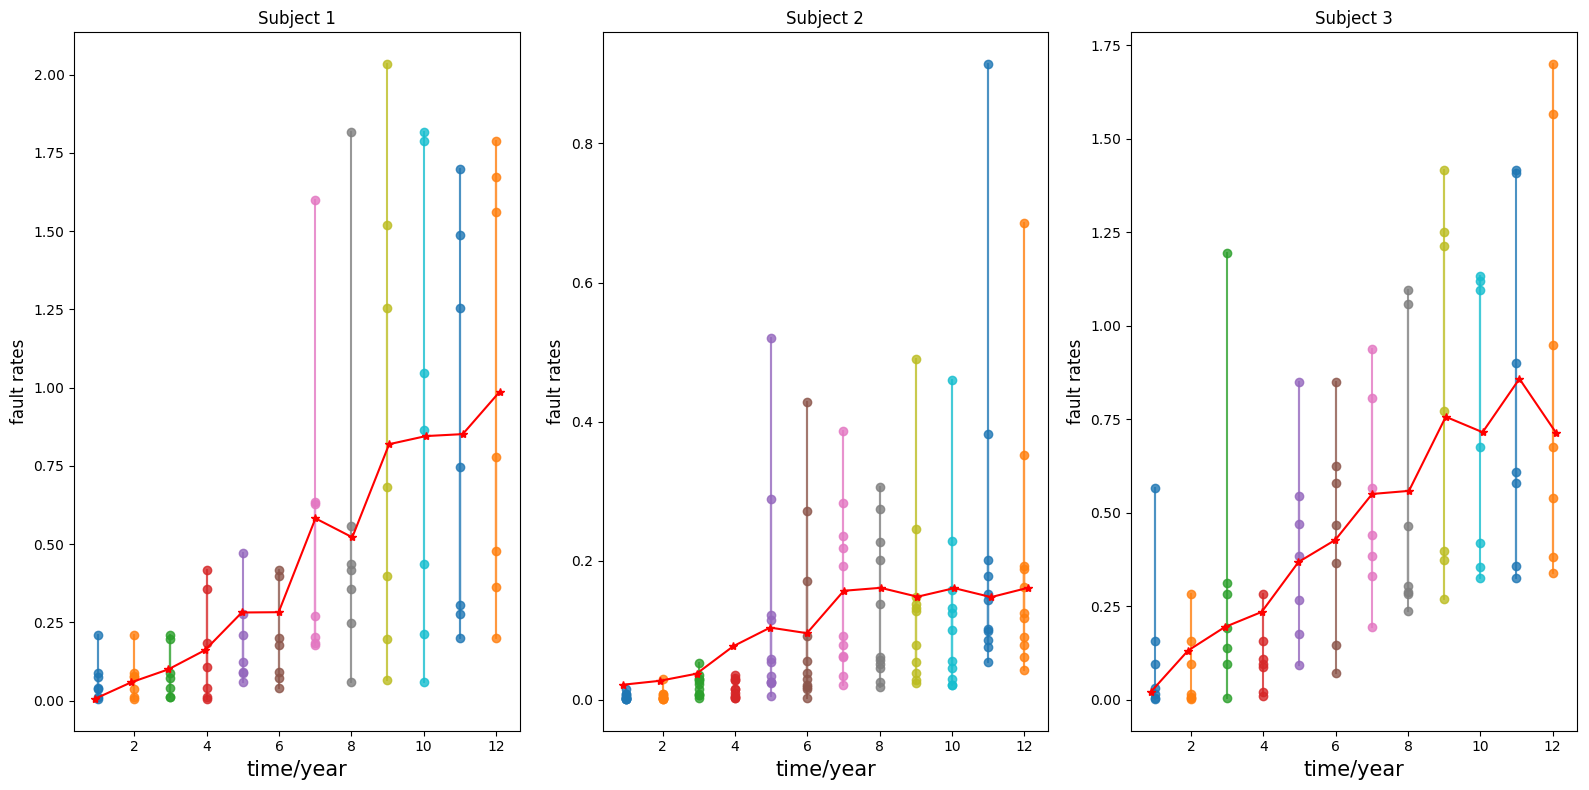

In [43]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 3)
xipred = np.array(np.arange(6) + 1)

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]*Norm_year_std + Norm_year_Mean
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    if ip==1:
        xp = elec_year2[ip*7:((ip+1)*7+4), :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[ip*7:((ip+1)*7+4), :]
    if ip==2:
        xp = elec_year2[18:25, :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[18:25, :]
        
    xl = np.linspace(0.9, 12.1, 12)
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = Y_NNpred[ip]

    ax.plot(xl, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [44]:
RmseTrain_NN, MAETrain_NN, MAPETrain_NN  = RMSE(elec_faults_NN, Y_NNpred, Len_One=12, Zoom_factor=100)
print('RMSE:', RmseTrain_NN)
print('MAE: ',MAETrain_NN)
print('MAPE:',MAPETrain_NN)

Rmse Mean is A、B、C :
RMSE: {0: 0.005639130884563218, 1: 0.0011929174186868282, 2: 0.005249723030615133}
MAE:  {0: 0.004534768667251758, 1: 0.0010710706183516975, 2: 0.004564961702766897}
MAPE: {0: 271.8561357226259, 1: 443.9355007953753, 2: 377.40477717134144}


In [46]:
# np.savetxt('E:/Code/Bayescode/QW_reliable/LOFG_BN/Picture/Y_SVMpred.csv', Y_SVMpred, delimiter = ',')
# np.savetxt('E:/Code/Bayescode/QW_reliable/LOFG_BN/Picture/Y_NNpred.csv', Y_NNpred, delimiter = ',')

In [ ]:
# 